Import libraries

In [32]:
#!pip install pyarrow
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
from pathlib import Path
from datetime import datetime
import re
import os
import random

Setting the current working directory

In [33]:
script_directory = os.getcwd()
os.chdir(script_directory)

Load data

In [35]:
import gzip
import json
# Specify the path to your JSON Lines file
file_path = 'Arxiv_data/arxiv-abstracts.jsonl.gz'

# Open the gzipped JSON Lines file
with gzip.open(file_path, 'rt', encoding='utf-8') as file:
    # Read a random subset of lines (adjust the sample_size as needed)
    sample_size = 500000  # Adjust this number as needed
    data = [json.loads(line) for line in random.sample(file.readlines(), sample_size)]

# Convert the list of dictionaries into a pandas DataFrame
df = pd.DataFrame(data)

# Display the first few rows of the DataFrame
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions
0,1609.05192,Eduardo Guerras,"Eduardo Guerras, Xinyu Dai, Shaun Steele, Ang ...",Extended X-ray Monitoring of Gravitational Len...,None,None,10.3847/1538-4357/aa5728,We present an X-ray photometric analysis of ...,None,[astro-ph.HE astro-ph.GA],"[v1, v2]"
1,astro-ph/0205047,Belli Pierluigi,"R. Bernabei, M. Amato, P. Belli, F. Cappella, ...",WIMP Search by DAMA at Gran Sasso,"Talk at DARK2002 Conference, Cape Town, South ...","""Dark matter in astro- and particle Physics"", ...",10.1016/S0920-5632(03)02101-7,DAMA is searching for rare processes by deve...,None,[astro-ph],[v1]
2,0804.3607,Lilia Solovyeva,"L. Solovyeva, S. Anokhin, L. Feretti, J.L. Sau...",The dynamical state of A548 from XMM-Newton da...,"A&A, accepted March 20, 2008, (better quality ...",None,10.1051/0004-6361:200809445,We present a detailed study of the X-ray pro...,None,[astro-ph],"[v1, v2]"
3,2012.12678,David Young,"David R. Young, Marco Landoni, Stephen J. Smar...",The SOXS Data-Reduction Pipeline,"15 pages, 11 figures. SPIE 2020",None,None,The SOXS is a dual-arm spectrograph (UV-VIS ...,None,[astro-ph.IM],[v1]
4,cs/0106046,Floris Geerts,Floris Geerts,Expressing the cone radius in the relational c...,9 pages,None,None,We show that there is a query expressible in...,None,[cs.DB cs.LO],[v1]


Function to encode abstracts with 'dates'

In [36]:
# Extract publication dates from arXiv IDs and create a new 'publication_date' column
def extract_date(x):
    year_month = re.search(r'(\d{2})(\d{2})', x)
    if year_month:
        year, month = year_month.groups()
        return datetime.strptime(f"{year}-{month}-01", "%y-%m-%d")
    else:
        return None

df['publication_date'] = df['id'].apply(extract_date)

# Display the first few rows of the DataFrame with the new 'publication_date' column
df.head()

,id,submitter,authors,title,comments,journal-ref,doi,abstract,report-no,categories,versions,publication_date
0,1609.05192,Eduardo Guerras,"Eduardo Guerras, Xinyu Dai, Shaun Steele, Ang ...",Extended X-ray Monitoring of Gravitational Len...,None,None,10.3847/1538-4357/aa5728,We present an X-ray photometric analysis of ...,None,[astro-ph.HE astro-ph.GA],"[v1, v2]",2016-09-01
1,astro-ph/0205047,Belli Pierluigi,"R. Bernabei, M. Amato, P. Belli, F. Cappella, ...",WIMP Search by DAMA at Gran Sasso,"Talk at DARK2002 Conference, Cape Town, South ...","""Dark matter in astro- and particle Physics"", ...",10.1016/S0920-5632(03)02101-7,DAMA is searching for rare processes by deve...,None,[astro-ph],[v1],2002-05-01
2,0804.3607,Lilia Solovyeva,"L. Solovyeva, S. Anokhin, L. Feretti, J.L. Sau...",The dynamical state of A548 from XMM-Newton da...,"A&A, accepted March 20, 2008, (better quality ...",None,10.1051/0004-6361:200809445,We present a detailed study of the X-ray pro...,None,[astro-ph],"[v1, v2]",2008-04-01
3,2012.12678,David Young,"David R. Young, Marco Landoni, Stephen J. Smar...",The SOXS Data-Reduction Pipeline,"15 pages, 11 figures. SPIE 2020",None,None,The SOXS is a dual-arm spectrograph (UV-VIS ...,None,[astro-ph.IM],[v1],2020-12-01
4,cs/0106046,Floris Geerts,Floris Geerts,Expressing the cone radius in the relational c...,9 pages,None,None,We show that there is a query expressible in...,None,[cs.DB cs.LO],[v1],2001-06-01


Sort the dataframe wrt. publication 'date'

In [37]:
# Sort the DataFrame in descending order based on 'publication_date'
df_sorted = df.sort_values(by='publication_date', ascending=False)

# Display the sorted DataFrame
#df_sorted.tail()
#df_sorted.head()

## What topics were hot during covid?

In [38]:
# Subset the sorted DataFrame based on the COVID-19 period feb. 2020 - dec 2021
df_covid = df_sorted[(df_sorted['publication_date'] >= '2020-02-01')]

df_covid.head()
df_covid.tail()

df_covid.shape

(87183, 12)

**Topic Modelling with Latent Dirichlet Analysis (LDA) on abstracts from articles published during COVID-19:**

1. Data preprocessing

In [ ]:
###########################################################################
###  Function to subset the df_covid dataframe for faster code testing. ###
###  Run with the entire df_covid for final run.                        ###
###########################################################################
## MAYBE NOT NECESSARY WHEN GPU - CHECK THIS
import pandas as pd

def subset_dataframe_percentage(df, percentage):
       # Subset based on the date range
    df_covid = df[df['publication_date'] >= '2020-02-01']

    # Calculate the number of rows based on the percentage
    num_rows = int(percentage * len(df_covid))

    # Use sample to randomly select rows
    subset = df_covid.sample(n=num_rows, random_state=42)  # You can change the random_state if needed

    return subset

# Assuming df_sorted is your original DataFrame
percentage_to_subset = 0.2  # Change this value to the desired percentage
df_covid_subset = subset_dataframe_percentage(df_covid, percentage_to_subset)

# Print the head, tail, and shape of the subset
print(f"Subset shape: {df_covid_subset.shape}")

In [40]:
#!pip install nltk
import random
import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer

# Assuming df is your DataFrame and 'abstract' is the column with abstracts
abstracts = df_covid['abstract'].tolist()
# Shuffle the abstracts for variety
random.shuffle(abstracts)

# Load lemmatizer
lemmatizer = WordNetLemmatizer()                # The process of lemmatization reduces words to their base or root form (Grouping together different forms of the same word).
stop_words = set(stopwords.words('english'))    # Common words are removed as they often does not contribute the overall meaning of the text.

# Process each abstract by tokenizing, lemmatizing, and removing stop words - resulting in the cleaned_abstracts list containing the cleaned documents.
cleaned_abstracts = []
for abstract in abstracts:
    # Tokenize and lemmatize
    tokens = word_tokenize(abstract.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalnum()] #isalnum checks whether all characters in the token are alphanumeric. Helps filter out tokens that may contain non-alphanumeric characters before lemmatizing 
    # Remove stop words
    filtered_tokens = [token for token in lemmatized_tokens if token not in stop_words]
    cleaned_abstracts.append(' '.join(filtered_tokens))

# VISUALIZE SOME CLEANED_ABSTRACTS
print("Example cleaned abstracts:")
for i in range(5):
    print(f"Abstract {i + 1}: {cleaned_abstracts[i]}")

#  Utilizing CountVectorizer() to create a Bag of Words matrix (X) where each row represents an abstract,
#  and each column represents a unique word in the vocabulary - The cells represent the counts.
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(cleaned_abstracts)

Example cleaned abstracts:
Abstract 1: origin supermassive black hole early universe redshift z 7 remains poorly understood gravitational collapse massive primordial gas cloud promising initial process theoretical study difficulty growing black hole fast enough focus magnetic effect star formation occurs gas cloud using set magnetohydrodynamic mhd simulation investigate star formation process magnetized gas cloud different initial magnetic field strength simulation show primordial magnetic seed field quickly amplified early accretion phase first protostar formation strong magnetic field efficiently extract angular momentum accreting gas increase accretion rate result high fragmentation rate gravitationally unstable disk region hand coalescence rate fragment also enhanced angular momentum transfer due magnetic effect almost fragment coalesce primary star mass growth rate massive star increase due magnetic effect conclude magnetic effect support direct collapse scenario supermassive star

2. Dimensionality reduction

In [42]:
print(f'Shape after filtering: {X.shape}')
# At this point we have our feature matrix X containing Bag of Word representation of our abstracts. The abstracts has been lemmatized and stopwords has been removed.
# Each row in X represents an abstract, and each column represents a unique word in the vocabulary.
# There are 88103 columns after vectorizing, representing 88103 unique words.

# The sum of each column will represent the total count of the unique words across all the abstracts in the subsetted corpus.
word_frequencies = X.sum(axis=0)
#print(word_frequencies)

# Convert to a numpy array for easier manipulation
word_frequencies_array = word_frequencies.A1

# Sort indices in descending order based on wordfrequencies
sorted_indices = np.argsort(word_frequencies_array)[::-1]

# Calculate the cumulative sum of word frequencies
cumulative_sum = np.cumsum(word_frequencies_array[sorted_indices])

# Calculate the total sum of word frequencies
total_sum = cumulative_sum[-1]

# Set the percentage of top words to keep
percentage_to_keep = 0.90

# Find the index where cumulative sum exceeds the specified percentage of total tokens
threshold_index = np.argmax(cumulative_sum >= percentage_to_keep * total_sum)

# Select only the top elements up to the threshold index
selected_indices = sorted_indices[:threshold_index + 1]
X_filtered = X[:, selected_indices]

# Extract liste of words in retained parts of X
feature_names = np.array(vectorizer.get_feature_names_out())
retained_tokens = feature_names[selected_indices].tolist()

print(f'Shape after dimension reduction: {X_filtered.shape}') # Fewer columns - reduced from 60,903 to 5,288.

Shape after filtering: (87183, 99513)
Shape after dimension reduction: (87183, 5333)


3. Determine the optimal number of topics using elbow point

fitting num_topics = 5
perplexity for 5 topics: 1630.1972420016548
fitting num_topics = 6
perplexity for 6 topics: 1555.8755669643056
fitting num_topics = 7
perplexity for 7 topics: 1548.1930213614025
Differences in perplexity: [-74.32167504  -7.6825456 ]


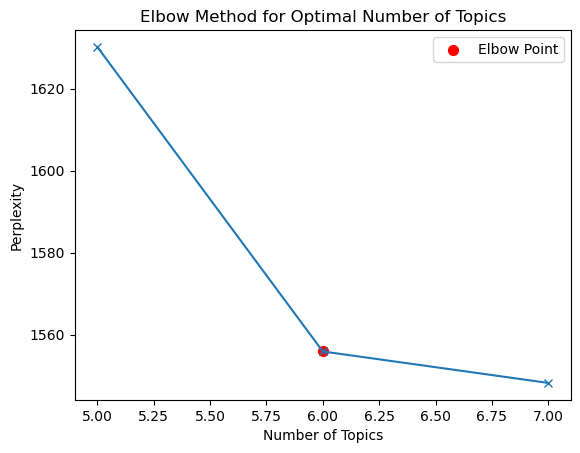

Optimal Number of Topics (Elbow Point): 6


In [51]:
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Input the Bag of Words representation (X_filtered) as input to LDA to discover underlying topics in your abstracts based on word co-occurrence patterns.

# Initialize an empty list to store evaluation metric values
eval_metric_values = []

# Define the range of number of topics to be tried
num_topics_range = range(5, 8)

# Loop over each number of topics
for num_topics in num_topics_range:
    print(f'fitting num_topics = {num_topics}')

    # Create an LDA model with the current number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    # Fit the LDA model to the filtered feature matrix (X_filtered)
    lda.fit(X_filtered)

    # Evaluation metric (perplexity --> measures coherence within topics)
    perplexity = lda.perplexity(X_filtered)
    print(f'perplexity for {num_topics} topics: {perplexity}')

    eval_metric_values.append(perplexity)

 
# Identify the elbow point using differences in perplexity values
diffs = np.diff(eval_metric_values)
print("Differences in perplexity:", diffs)

# Find the index where the rate of change (slope) decreases the most
elbow_point = np.argmin(diffs) + 6  # Add 6 because we started from num_topics=5

# Plot the evaluation metric values against the number of topics
plt.plot(num_topics_range, eval_metric_values, marker='x')
plt.title('Elbow Method for Optimal Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')

# Mark the elbow point on the plot
plt.scatter(elbow_point, eval_metric_values[elbow_point - 5], c='red', label='Elbow Point', marker='o', s=50)
plt.legend()

plt.show()

# Print the identified optimal number of topics
print(f"Optimal Number of Topics (Elbow Point): {elbow_point}")



In [ ]:
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
import gensim

# Convert cleaned_abstracts to a list of lists
tokenized_abstracts = [doc.split() for doc in cleaned_abstracts]

# Create a Gensim Dictionary
gensim_dictionary = Dictionary(tokenized_abstracts)

# Initialize an empty list to store evaluation metric values
eval_metric_values = []

# Define the range of number of topics to be tried
num_topics_range = range(5, 13)

# Convert your Bag of Words matrix to Gensim format
corpus = gensim.matutils.Sparse2Corpus(X_filtered.T)

# Loop over each number of topics
for num_topics in num_topics_range:
    print(f'fitting num_topics = {num_topics}')

    # Create an LDA model with the current number of topics
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    # Fit the LDA model to the filtered feature matrix (X_filtered)
    lda.fit(X_filtered)

    # Convert the LDA model to Gensim format
    lda_gensim = gensim.models.ldamodel.LdaModel(corpus, num_topics=num_topics, id2word=dict(enumerate(feature_names)))

    # Calculate coherence
    coherence_model_lda = CoherenceModel(model=lda_gensim, texts=tokenized_abstracts, dictionary=gensim_dictionary, coherence='c_v')

    coherence = coherence_model_lda.get_coherence()
    print(f'coherence for {num_topics} topics: {coherence}')

    eval_metric_values.append(coherence)


diffs = np.diff(eval_metric_values)
print("Differences in coherence:", diffs)

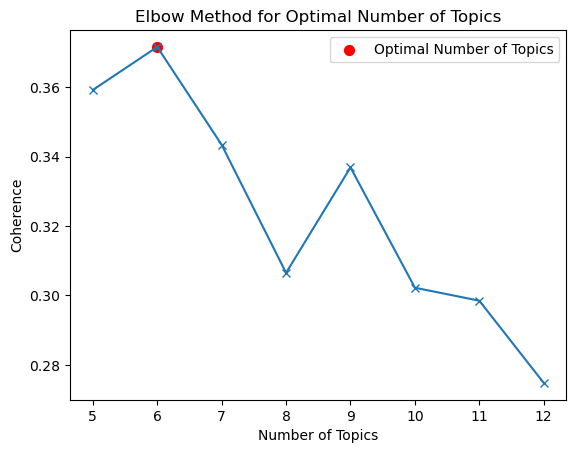

Optimal Number of Topics (Elbow Point): 5


In [48]:

# Plot the evaluation metric values against the number of topics
plt.plot(num_topics_range, eval_metric_values, marker='x')
plt.title('Elbow Method for Optimal Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')  

# Identify the elbow point using differences in coherence values
max_coherence_index = eval_metric_values.index(max(eval_metric_values))
optimal_num_topics = num_topics_range[max_coherence_index]
max_coherence_value = eval_metric_values[max_coherence_index]

# Mark the elbow point on the plot
plt.scatter(optimal_num_topics, max_coherence_value, c='red', label='Optimal Number of Topics', marker='o', s=50)
plt.legend()

plt.show()

# Print the identified optimal number of topics
print(f"Optimal Number of Topics (Elbow Point): {elbow_point}")

Refitting model with optimal # topics

In [52]:
# Refit with optimal topics
lda = LatentDirichletAllocation(n_components=elbow_point, random_state=20)
lda.fit(X_filtered)

LatentDirichletAllocation(n_components=6, random_state=20)

Display the top words for each topic

In [59]:
# Display the top words for each topic
feature_names = np.array(vectorizer.get_feature_names_out())[selected_indices]

print("Top words for each topic:")
for topic_id, topic in enumerate(lda.components_):
    top_word_indices = topic.argsort()[:-11:-1]  # Get the indices of the top 10 words
    top_words = feature_names[top_word_indices]
    print(f"Topic {topic_id + 1}: {', '.join(top_words)}\n{'-'*50}")

Top words for each topic:
Topic 1: system, network, model, data, paper, performance, learning, control, algorithm, design
--------------------------------------------------
Topic 2: method, problem, algorithm, model, graph, function, result, show, number, data
--------------------------------------------------
Topic 3: state, phase, quantum, magnetic, field, effect, system, temperature, energy, transition
--------------------------------------------------
Topic 4: equation, model, theory, result, system, function, solution, space, quantum, field
--------------------------------------------------
Topic 5: model, data, method, image, learning, network, task, feature, approach, performance
--------------------------------------------------
Topic 6: star, mass, galaxy, group, model, show, observation, result, find, also
--------------------------------------------------


## NEXT THING ON THE LIST

In [ ]:
# Doing oneshot classification on the abstracts

In [ ]:
# Import the pandas library
import pandas as pd

# Assuming df is your DataFrame
# Filter rows where the 'categories' column contains 'nlp'
nlp_papers = df[df['categories'].str.contains('nlp', case=False, na=False)]

# Display the resulting DataFrame
print(nlp_papers)
